## Part1: Data_Preprocessing

In [1]:
# Import necessary libraries
import tensorflow as tf  # TensorFlow for deep learning and model handling
import numpy as np  # NumPy for numerical operations and array handling
import matplotlib.pyplot as plt  # Matplotlib for plotting images and results
import os  # OS module for interacting with the file system

In [2]:
# Define the target image size for resizing all images in the dataset  
IMG_SIZE = (224, 224)  # Images will be resized to 224x224 pixels  

# Define the batch size for training and validation  
BATCH_SIZE = 32  # Number of images processed together in one batch  

# Define the dataset path where the flower images are stored  
DATASET_PATH = r"C:\Users\Admin\Desktop\Deccan_AI\flowers_dataset"  # Raw string (r"") to handle Windows file paths correctly

In [3]:
try:
    # Load the dataset from the specified directory and split it into training and validation sets
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        DATASET_PATH,       # Path to the dataset folder containing subdirectories for each class
        validation_split=0.3,  # 30% of the data will be used for validation
        subset="training",  # Load the training subset (remaining 70% of the data)
        seed=123,  # Random seed to ensure reproducibility when splitting data
        image_size=(224, 224),  # Resize all images to 224x224 pixels
        batch_size=32  # Number of images per batch for training
    )
    
    print("✅ Dataset loaded successfully!")  # Success message if dataset loads correctly

except Exception as e:
    print("❌ Error loading dataset:", e)  # Print error message if dataset loading fails

Found 4317 files belonging to 5 classes.
Using 3022 files for training.
✅ Dataset loaded successfully!


In [4]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,          # Path to the dataset folder containing subdirectories for each class
    validation_split=0.15,  # 15% of the data will be used for validation
    subset="validation",    # Load the validation subset
    seed=123,               # Random seed to ensure reproducibility when splitting data
    image_size=IMG_SIZE,    # Resize all images to the defined image size (224x224 pixels)
    batch_size=BATCH_SIZE   # Number of images per batch for validation (same as training)
)

Found 4317 files belonging to 5 classes.
Using 647 files for validation.


In [5]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,          # Path to the dataset folder containing subdirectories for each class
    validation_split=0.15,  # 15% of the data will be used for testing
    subset="validation",    # Load the validation subset (used as the test set here)
    seed=456,               # Different seed to create a separate test dataset from validation
    image_size=IMG_SIZE,    # Resize all images to the defined image size (224x224 pixels)
    batch_size=BATCH_SIZE   # Number of images per batch for testing (same as training/validation)
)

Found 4317 files belonging to 5 classes.
Using 647 files for validation.


In [6]:
# Retrieve the class names from the training dataset  
class_names = train_ds.class_names  

# Print the class names (categories of flowers in the dataset)  
print("Class Names:", class_names)  

Class Names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


In [7]:
# Create a normalization layer to scale pixel values from [0, 255] to [0, 1]
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Apply normalization to the training dataset
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))  
# Each image `x` is passed through the normalization layer, labels `y` remain unchanged

# Apply normalization to the validation dataset
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))  

# Apply normalization to the test dataset
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))  

In [8]:
# Create a data augmentation pipeline using Sequential API  
data_augmentation = tf.keras.Sequential([  
    tf.keras.layers.RandomFlip("horizontal"),  # Randomly flip images horizontally (left-right)  
    tf.keras.layers.RandomRotation(0.2),  # Randomly rotate images by up to 20%  
    tf.keras.layers.RandomZoom(0.2)  # Randomly zoom images by up to 20%  
])  

In [9]:
# Apply data augmentation to the training dataset
train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))  
# `data_augmentation(x, training=True)`: Ensures augmentations are applied only during training
# Labels `y` remain unchanged

In [10]:
# Set AUTOTUNE for optimizing data loading performance  
AUTOTUNE = tf.data.AUTOTUNE  

# Optimize the training dataset pipeline  
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)  
# `.cache()`: Stores the dataset in memory/disk to avoid redundant reads  
# `.shuffle(1000)`: Randomly shuffles 1000 samples to improve training randomness  
# `.prefetch(AUTOTUNE)`: Prefetches data in the background to improve training efficiency  

# Optimize the validation dataset pipeline  
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)  
# `.cache()`: Caches validation data for faster access  
# `.prefetch(AUTOTUNE)`: Loads the next batch while the current batch is being processed  

# Optimize the test dataset pipeline  
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)  
# `.cache()`: Caches test data for faster evaluation  
# `.prefetch(AUTOTUNE)`: Reduces I/O latency by preloading the next batch  

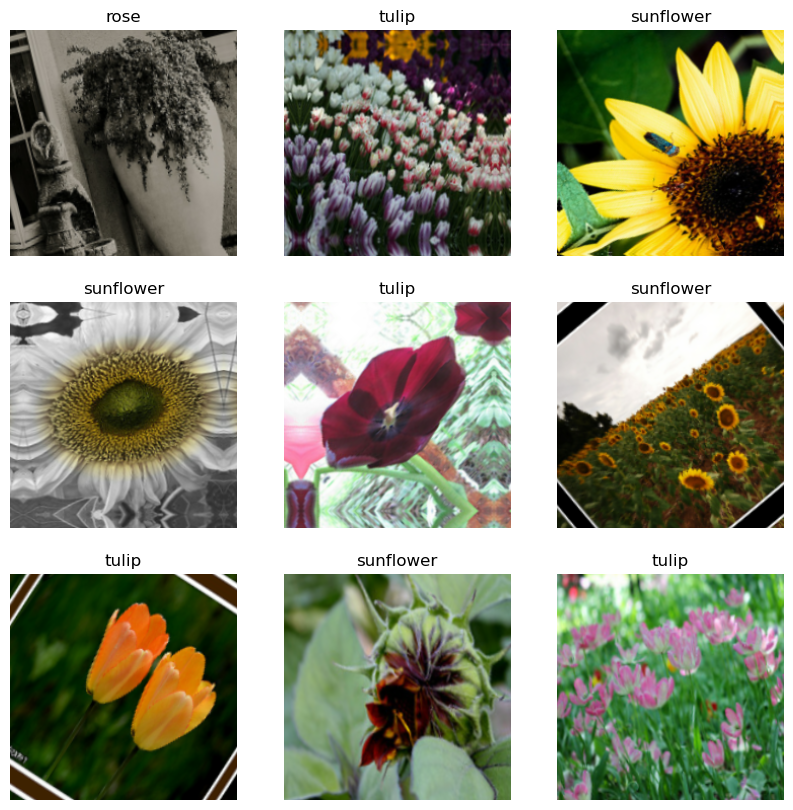

In [11]:
# Create a figure for displaying images with a size of 10x10 inches  
plt.figure(figsize=(10, 10))  

# Take one batch of images and labels from the training dataset  
for images, labels in train_ds.take(1):  
    # Loop through the first 9 images in the batch  
    for i in range(9):  
        ax = plt.subplot(3, 3, i + 1)  # Create a 3x3 grid for displaying images  
        plt.imshow(images[i].numpy())  # Convert image tensor to a NumPy array and display it  
        plt.title(class_names[labels[i]])  # Set the title as the corresponding class name  
        plt.axis("off")  # Hide the axes for better visualization  

# Show the plotted images  
plt.show()  

## Part 2: Model Training & Evaluation

In [12]:
# Load the pre-trained MobileNetV2 model as the base model  
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Define input shape (224x224 pixels, 3 color channels - RGB)
    include_top=False,  # Exclude the fully connected (top) layers of MobileNetV2  
    weights="imagenet"  # Load pre-trained weights from the ImageNet dataset  
)  

# Freeze the pre-trained layers to prevent them from being updated during training  
base_model.trainable = False  

In [13]:
# Define the final model using Sequential API  
model = tf.keras.Sequential([  
    base_model,  # Use the pre-trained MobileNetV2 as the feature extractor  

    tf.keras.layers.GlobalAveragePooling2D(),  
    # Replaces the dense layers of MobileNetV2 with Global Average Pooling  
    # Reduces the spatial dimensions of the feature maps  
    # Helps prevent overfitting by reducing the number of trainable parameters  

    tf.keras.layers.Dense(256, activation="relu"),  
    # Fully connected (Dense) layer with 256 neurons and ReLU activation  
    # Learns complex patterns from extracted features  

    tf.keras.layers.Dropout(0.3),  
    # Dropout layer with a 30% dropout rate  
    # Helps prevent overfitting by randomly dropping connections during training  

    tf.keras.layers.Dense(len(class_names), activation="softmax")  
    # Output layer with neurons equal to the number of flower classes  
    # Uses softmax activation for multi-class classification (probabilities for each class)  
])  

In [14]:
# Compile the model with an optimizer, loss function, and evaluation metrics  
model.compile(  
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  
    # Adam optimizer with a learning rate of 0.001  
    # Adam is adaptive and efficient, making it a good choice for deep learning models  

    loss="sparse_categorical_crossentropy",  
    # Loss function for multi-class classification when labels are integers  
    # Use "categorical_crossentropy" if labels are one-hot encoded  

    metrics=["accuracy"]  
    # Track accuracy during training and evaluation  
)  

In [15]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau  

EPOCHS = 2  # Number of times the model will train over the entire dataset (adjust as needed)  

# ✅ Define Callbacks  

# EarlyStopping: Stop training if validation loss does not improve for 3 consecutive epochs  
early_stopping = EarlyStopping(  
    monitor="val_loss",  # Monitor validation loss  
    patience=3,  # Stop training if no improvement after 3 epochs  
    restore_best_weights=True  # Restore the best model weights after stopping  
)  

# ReduceLROnPlateau: Reduce learning rate if validation loss stops improving  
lr_scheduler = ReduceLROnPlateau(  
    monitor="val_loss",  # Monitor validation loss  
    factor=0.5,  # Reduce learning rate by a factor of 0.5  
    patience=2  # Wait for 2 epochs before reducing learning rate  
)  

# Train the model with training data, validation data, and callbacks  
history = model.fit(  
    train_ds,  # Training dataset  
    validation_data=val_ds,  # Validation dataset  
    epochs=EPOCHS,  # Number of epochs  
    callbacks=[early_stopping, lr_scheduler]  # Use defined callbacks  
)  


Epoch 1/2
95/95 ━━━━━━━━━━━━━━━━━━━━ 82s 756ms/step - accuracy: 0.6275 - loss: 1.0024 - val_accuracy: 0.8114 - val_loss: 0.4955 - learning_rate: 0.0010
Epoch 2/2
95/95 ━━━━━━━━━━━━━━━━━━━━ 68s 715ms/step - accuracy: 0.8370 - loss: 0.4479 - val_accuracy: 0.8501 - val_loss: 0.4118 - learning_rate: 0.0010


In [16]:
import pickle  

# ✅ Save the trained model as a .keras file  
model.save("flower_classification_model.keras")  
# Saves the entire model (architecture, weights, and optimizer state)  
# The `.keras` format is preferred for TensorFlow 2.x, but `.h5` also works  

# ✅ Use Pickle to store the model file path  
with open("flower_model.pkl", "wb") as f:  
    pickle.dump("flower_classification_model.keras", f)  
# Pickle is used to serialize and store the model's file path for later use  
# This does NOT save the actual model, just the file name as a string  


In [17]:
# ✅ Evaluate the Model  

val_labels = []  # List to store true labels from the validation set  
val_preds = []  # List to store predicted labels from the model  

# Loop through batches of images and labels in the validation dataset  
for images, labels in val_ds:  
    predictions = model.predict(images)  # Get model predictions for the batch  
    val_preds.extend(np.argmax(predictions, axis=1))  
    # Convert softmax probabilities into class indices (predicted labels)  
    # `np.argmax(predictions, axis=1)` selects the class with the highest probability  

    val_labels.extend(labels.numpy())  
    # Convert TensorFlow tensor labels to NumPy arrays and store them  


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 588ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 636ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 623ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 624ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 632ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 593ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 587ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 589ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 600ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 640ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


In [18]:
from sklearn.metrics import classification_report, confusion_matrix  

# ✅ Generate and print the classification report  
print("\nClassification Report:")  
print(classification_report(val_labels, val_preds, target_names=class_names))  
# `classification_report()` provides precision, recall, F1-score, and support for each class  
# `val_labels`: True class labels from the validation dataset  
# `val_preds`: Model-predicted class labels  
# `target_names=class_names`: Maps numerical labels to their corresponding class names  



Classification Report:
              precision    recall  f1-score   support

       daisy       0.86      0.92      0.89       110
   dandelion       0.94      0.88      0.91       153
        rose       0.83      0.68      0.74       108
   sunflower       0.91      0.84      0.87       117
       tulip       0.75      0.90      0.82       159

    accuracy                           0.85       647
   macro avg       0.86      0.84      0.85       647
weighted avg       0.86      0.85      0.85       647



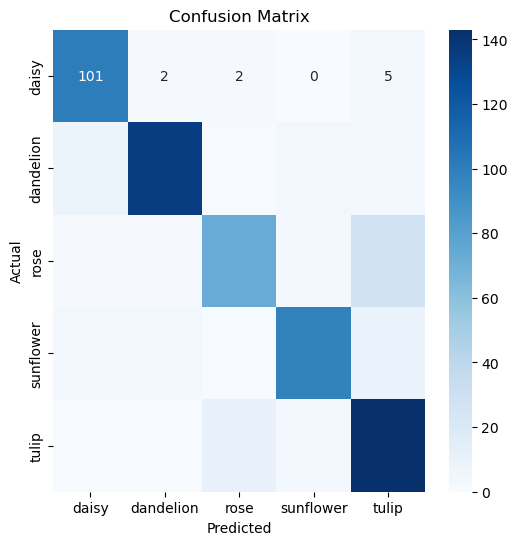

In [19]:
import seaborn as sns  

# ✅ Compute the Confusion Matrix  
conf_matrix = confusion_matrix(val_labels, val_preds)  
# `confusion_matrix()` compares actual vs. predicted labels  
# Rows represent actual classes, and columns represent predicted classes  

# ✅ Visualize the Confusion Matrix  
plt.figure(figsize=(6, 6))  # Set the figure size  

sns.heatmap(conf_matrix, annot=True, cmap="Blues",  
            xticklabels=class_names, yticklabels=class_names, fmt="d")  
# `annot=True`: Displays the values in the matrix  
# `cmap="Blues"`: Uses a blue color gradient for better readability  
# `xticklabels=class_names, yticklabels=class_names`: Labels the axes with class names  
# `fmt="d"`: Ensures the numbers in the matrix are displayed as integers  

plt.xlabel("Predicted")  # Label the x-axis (Predicted classes)  
plt.ylabel("Actual")  # Label the y-axis (Actual classes)  
plt.title("Confusion Matrix")  # Set the plot title  

plt.show()  # Display the heatmap  

## Part 3: Model Deployment

In [20]:
from fastapi import FastAPI, File, UploadFile, HTTPException, Depends  
# ✅ FastAPI: A modern web framework for building APIs in Python  
# `FastAPI`: Main framework to create the API  
# `File, UploadFile`: Handle file uploads (e.g., image files)  
# `HTTPException`: Used to raise HTTP errors in case of invalid requests  
# `Depends`: Handles dependencies like authentication  

from fastapi.security import HTTPBasic, HTTPBasicCredentials  
# ✅ HTTP Basic Authentication for securing API endpoints  
# `HTTPBasic`: Implements basic authentication (username & password)  
# `HTTPBasicCredentials`: Stores username and password  

from PIL import Image  
# ✅ PIL (Pillow) for image processing  
# `Image`: Used to open and process images  

import io  
# ✅ `io` module is used for in-memory file handling  
# Allows reading and writing image data in bytes  

import nest_asyncio  
# ✅ `nest_asyncio` allows running FastAPI inside Jupyter notebooks (if needed)  
# Enables event loop re-entry when using FastAPI in interactive environments  

import uvicorn  
# ✅ `uvicorn` is an ASGI server used to run FastAPI applications  
# It is a high-performance web server designed for asynchronous frameworks  


In [21]:
import warnings  
warnings.filterwarnings("ignore")  
# ✅ Suppress warning messages  
# `warnings.filterwarnings("ignore")` disables all warning messages  
# Useful to prevent clutter in the console/logs  
# Does NOT affect critical errors—only warnings  


In [22]:
import nest_asyncio  
nest_asyncio.apply()  
# ✅ Allows running FastAPI inside Jupyter notebooks or interactive environments  
# `nest_asyncio.apply()` patches the event loop to allow re-entry  
# Prevents errors when running an already running event loop  

In [23]:
MODEL_PATH = "flower_classification_model.h5"  
# ✅ Define the file path of the saved model  
# This is the path where the trained model is stored  

model = tf.keras.models.load_model(MODEL_PATH, compile=False)  
# ✅ Load the pre-trained model from the specified path  
# `load_model()` restores the model architecture and weights  

# `compile=False`:  
# - Prevents recompiling the model upon loading  
# - Useful when performing inference (no need to define optimizer, loss, metrics)  
# - If you need to continue training, set `compile=True` and recompile with an optimizer  


In [24]:
# ✅ Define class names for the flower classification model  
CLASS_NAMES = ["daisy", "dandelion", "rose", "sunflower", "tulip"]  
# This list represents the five flower categories the model predicts  
# The order must match the class indices used during model training  


In [26]:
# Initialize FastAPI app
app = FastAPI()

In [27]:
# Basic authentication setup
security = HTTPBasic()

In [28]:
# Preprocess the image
def preprocess_image(image: Image.Image):
    try:
        image = image.convert("RGB")  # Ensure 3 channels
        image = image.resize((224, 224))  # Resize to model input size
        image = np.array(image) / 255.0  # Normalize
        image = np.expand_dims(image, axis=0)  # Add batch dimension
        return image
    except Exception as e:
        raise HTTPException(status_code=400, detail=f"Error processing image: {str(e)}")

In [29]:
from fastapi.responses import HTMLResponse  
# ✅ `HTMLResponse` allows returning HTML content from FastAPI endpoints  
# Used to serve a simple webpage for interacting with the API  

# ✅ Define the homepage route  
@app.get("/", response_class=HTMLResponse)  
async def home():  
    return """  
    <h1>FastAPI Image Classification</h1>  
    <p>Upload an image to classify flowers</p>  
    <form action="/predict/" method="post" enctype="multipart/form-data">  
        <input type="file" name="file">  <!-- File input for image upload -->  
        <input type="submit" value="Upload">  <!-- Submit button -->  
    </form>  
    """  


In [30]:
# ✅ Define the prediction endpoint  
@app.post("/predict/")  
async def predict(  
    file: UploadFile = File(...),  # Accept an image file from the request  
    credentials: HTTPBasicCredentials = Depends(security)  # Require authentication  
):  
    # ✅ Authentication check  
    if credentials.username != "admin" or credentials.password != "password":  
        raise HTTPException(status_code=401, detail="Invalid credentials")  
    # If incorrect username/password is provided, return a 401 Unauthorized error  

    # ✅ Read and preprocess the uploaded image  
    image_bytes = await file.read()  # Read the image file as bytes  
    image = Image.open(io.BytesIO(image_bytes))  # Convert bytes into a PIL image  
    processed_image = preprocess_image(image)  # Apply preprocessing for the model  

    # ✅ Perform model prediction  
    predictions = model.predict(processed_image)  # Get model predictions  
    predicted_class = CLASS_NAMES[np.argmax(predictions)]  # Get the predicted class  
    confidence = float(np.max(predictions))  # Get confidence score (highest probability)  

    # ✅ Return the prediction result as JSON  
    return {"prediction": predicted_class, "confidence": confidence}  

# ✅ Run FastAPI inside Jupyter Notebook  
uvicorn.run(app, host="127.0.0.1", port=8000)  
# Starts the FastAPI app locally on port 8000  
# `host="127.0.0.1"` makes it accessible on localhost only  

INFO:     Started server process [20452]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:8000 (Press CTRL+C to quit)


INFO:     127.0.0.1:50695 - "GET / HTTP/1.1" 200 OK
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
INFO:     127.0.0.1:50696 - "POST /predict/ HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [20452]
